In [1]:
!pip install EMD-signal
!pip install vnstock

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 658.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import PyEMD as pe
from vnstock import *

Observations:  1629
            Open  High   Low  Close   Volume Ticker
Time                                               
2017-06-02  3230  3330  3200   3280   411631    VND
2017-06-05  3320  3370  3270   3280   671582    VND
2017-06-06  3280  3320  3270   3320   174560    VND
2017-06-07  3320  3610  3320   3590  2332950    VND
2017-06-08  3640  3640  3510   3540   467477    VND
2017-06-09  3520  3660  3520   3560   726174    VND


<Axes: xlabel='Time'>

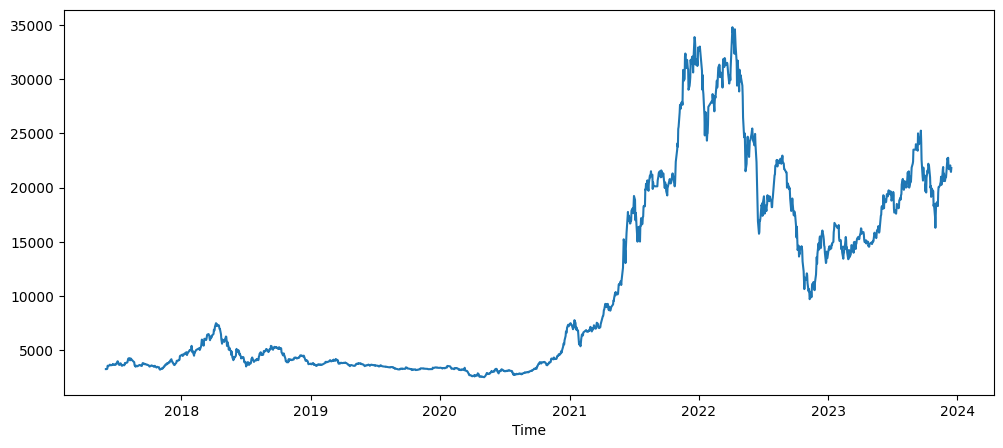

In [3]:
# Import data
VND = stock_historical_data(symbol = "VND", start_date="2017-06-01", end_date="2023-12-15", resolution="1D", type = "stock", beautify=True, decor=True, source = "DNSE")
from matplotlib import pyplot
print("Observations: ",len(VND['Close']))
print(pd.DataFrame(VND.head(6)))
train_dates = VND.index
plt.figure(figsize=(12, 5))
VND["Close"].plot()

In [4]:
VND = VND.reset_index(drop = True)
df = VND['Close']
df

0        3280
1        3280
2        3320
3        3590
4        3540
        ...  
1624    21950
1625    22050
1626    21600
1627    21450
1628    21800
Name: Close, Length: 1629, dtype: int64

In [5]:
## (A) CEEMDAN
#### 1. Thêm white noise vào chuỗi gốc s(t) thành chuỗi s1(t)
#### 2. Decompose chuỗi s1(t) bằng EMD ra các chuỗi IMF1 và Residue1
#### 3. Trung bình các chuỗi IMF1(t) thành mIMF1(t)
#### 4. r1(t) = s1(t) - mIMF1(t)
#### 5. Chuỗi mới s2(t) = r1(t) + coef*EMD(noise)
#### 6. Làm lại từ 1->5 đến khi chuỗi residue dừng

In [6]:
from PyEMD import EMD, CEEMDAN

In [7]:
ceemdan = CEEMDAN(range_thr=0.001, total_power_thr=0.01)
cIMFs = ceemdan.ceemdan(S=np.array(df.values), T= np.array(df.index))

In [8]:
pd.DataFrame(cIMFs.T, columns = ["IMF"+str(i+1) for i in range(cIMFs.shape[0])])

,IMF1,IMF2,IMF3,IMF4,IMF5,IMF6,IMF7
0,-49.142758,-37.766845,-75.451436,-81.901907,63.759691,-629.231385,4089.734640
1,-10.931427,-66.390830,-87.574749,-83.623935,79.053260,-637.230456,4086.698136
2,-72.748493,0.202717,-63.002075,-78.246296,95.070011,-644.947186,4083.671322
3,90.839760,42.649137,-16.620308,-66.906978,111.761334,-652.377118,4080.654174
4,-38.583817,50.625412,31.900610,-51.144749,129.071672,-659.515797,4077.646669
...,...,...,...,...,...,...,...
1624,165.236363,-528.594344,-42.094446,2981.402721,-2238.954174,4317.102300,17295.901580
1625,285.878803,-489.086084,-109.682433,2997.111271,-2236.327827,4308.268948,17293.837322
1626,-167.604038,-441.471398,-126.876798,2975.507600,-2230.758134,4299.324179,17291.878588
1627,-322.809606,-417.534043,-82.695803,2915.047868,-2222.313513,4290.280004,17290.025093


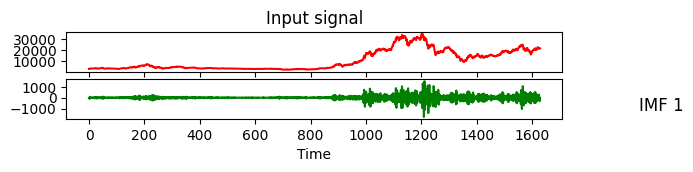

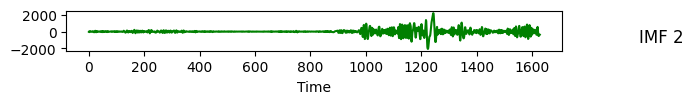

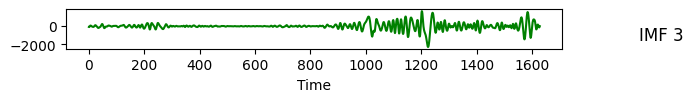

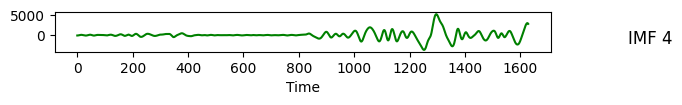

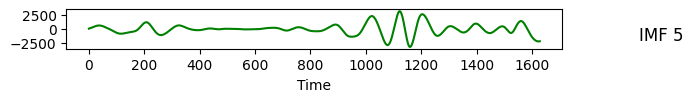

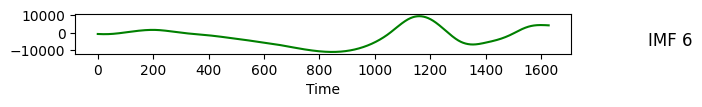

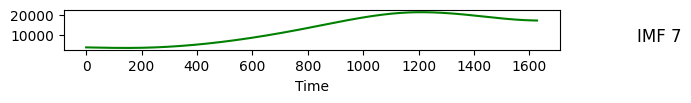

In [9]:
N = cIMFs.shape[0]+1
# Plot results
plt.subplot(N,1,1)
plt.plot(df.index, df.values, 'r')
plt.title("Input signal")
plt.xlabel("Time")

for n, imf in enumerate(cIMFs):
  plt.subplot(N,1,n+2)
  plt.plot(df.index, imf, 'g')
  plt.title("IMF "+str(n+1), x=1.2, y = 0)
  plt.xlabel("Time")
  plt.show()

In [10]:
# Tính residue
scIMF = cIMFs.sum(axis = 0).reshape(-1, 1)
residue = (np.array(df)-cIMFs.sum(axis = 0)).reshape(-1,1)

print("sIMF:", scIMF.shape)
print("Residue:", residue.shape)

sIMF: (1629, 1)
Residue: (1629, 1)


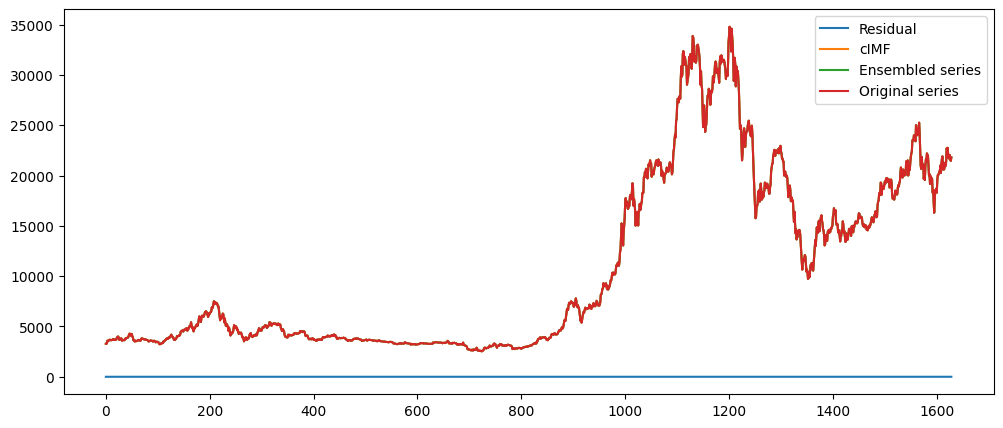

In [11]:
plt.figure(figsize=(12,5))
plt.plot(range(0,len(df)), residue)
plt.plot(range(0,len(df)), scIMF)
plt.plot(range(0,len(df)), scIMF+residue)
plt.plot(df)
plt.legend(["Residual", "cIMF", "Ensembled series", "Original series"])

plt.show()

In [12]:
# (B) LSTM
## 0. Prepocessing
# load các thư viện cần thiết
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder,StandardScaler,PowerTransformer, MinMaxScaler, RobustScaler

In [13]:
cIMF = cIMFs.sum(axis = 0).reshape(-1, 1)+residue
cIMF

array([[ 3280.],
       [ 3280.],
       [ 3320.],
       ...,
       [21600.],
       [21450.],
       [21800.]])

In [14]:
# Scale data to 0-1
scaler = StandardScaler()
def Scaling (data):
    IMFscale = scaler.fit_transform(np.array(data))

    return IMFscale
IMFscale = Scaling(cIMF)
#train_scaled = scaler.inverse_transform(train_scaled)
#pd.DataFrame(train_scaled, columns=["IMF"+str(i+1) for i in range(cIMFs.shape[0])])

(1629, 1)
Train:  (1140, 1)
Test:  (489, 1)


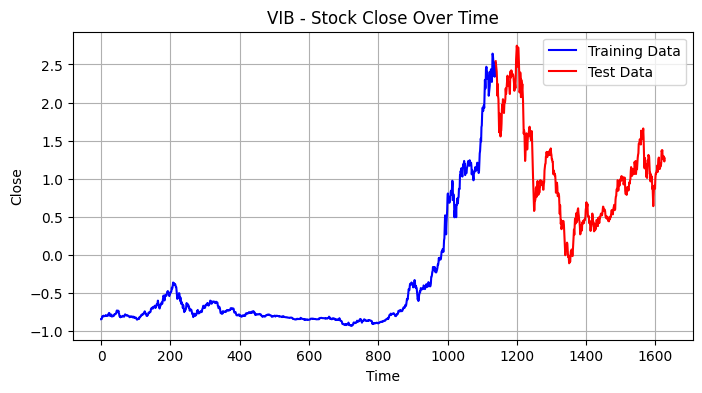

In [15]:
print(IMFscale.shape)
# Chia train test
train_size = int(0.7*IMFscale.shape[0])
test_size = int(0.3*IMFscale.shape[0])
train_data = IMFscale[:train_size].reshape(-1,1)
test_data = IMFscale[train_size:].reshape(-1,1)

print("Train: ", train_data.shape)
print("Test: ", test_data.shape)

# Plotting both training and test data on the same chart
plt.figure(figsize=(8, 4))

plt.plot(range(train_size), train_data, linestyle='-', color='b', label='Training Data')
plt.plot(range(train_size -1,  train_size+test_size), test_data, linestyle='-',  color='r', label='Test Data')


plt.title('VIB - Stock Close Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()

plt.show()

In [16]:
trainX = []
trainY = []

n_past = 60
n_future = 1

for i in range(n_past, len(train_data) - n_future + 1):
    past_sequence = train_data[i - n_past:i, 0:train_data.shape[1]]  # Exclude the first column ("Close") for trainX
    future_sequence = train_data[i + n_future - 1: i + n_future, 0]  # Use the "Close" column for trainY

    trainX.append(past_sequence)
    trainY.append(future_sequence)

trainX, trainY = np.array(trainX), np.array(trainY)
print("X train: ", trainX.shape)
print("Y train: ", trainY.shape)

X train:  (1080, 60, 1)
Y train:  (1080, 1)


In [17]:
testX = []
testY = []

for i in range(n_past, len(test_data) - n_future + 1):
    past_sequence = test_data[i - n_past:i, 0:test_data.shape[1]]  # Exclude the first column ("Close") for trainX
    future_sequence = test_data[i + n_future - 1: i + n_future, 0]  # Use the "Close" column for trainY

    testX.append(past_sequence)
    testY.append(future_sequence)

testX, testY = np.array(testX), np.array(testY)

print("X test: ", testX.shape)
print("Y test: ", testY.shape)

X test:  (429, 60, 1)
Y test:  (429, 1)


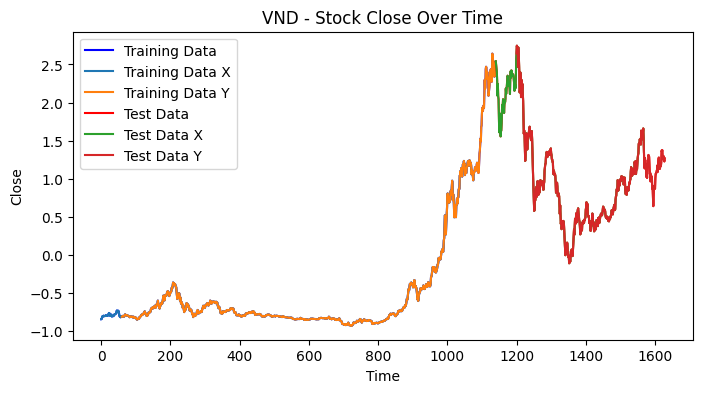

In [18]:
# Plotting both training and test data on the same chart
plt.figure(figsize=(8, 4))

plt.plot(range(train_size), train_data, linestyle='-', color='b', label='Training Data')
plt.plot(range(train_size-n_past), trainX[:,0,0], linestyle='-', label='Training Data X')
plt.plot(range(n_past,train_size), trainY[:,0], linestyle='-', label='Training Data Y')
plt.plot(range(train_size, train_size+test_size+1), test_data, linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size, train_size+test_size-n_past+1), testX[:,0,0], linestyle='-',  label='Test Data X')
plt.plot(range(train_size+n_past, train_size+test_size+1), testY[:,0], linestyle='-', label='Test Data Y')


plt.title('VND - Stock Close Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()

plt.show()

In [19]:
## 1. Train model
# Tạo model lstm cho việc training
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mape')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29345 (114.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# fit the model
history = model.fit(trainX, trainY, epochs=60, batch_size=4, validation_split=0.1, verbose=1)

Epoch 1/60
243/243 [==============================] - 13s 38ms/step - loss: 36.3806 - val_loss: 38.6861
Epoch 2/60
243/243 [==============================] - 9s 39ms/step - loss: 18.1368 - val_loss: 45.9097
Epoch 3/60
243/243 [==============================] - 8s 32ms/step - loss: 21.5146 - val_loss: 33.3275
Epoch 4/60
243/243 [==============================] - 9s 39ms/step - loss: 17.9832 - val_loss: 15.6218
Epoch 5/60
243/243 [==============================] - 10s 39ms/step - loss: 17.0622 - val_loss: 91.0736
Epoch 6/60
243/243 [==============================] - 8s 33ms/step - loss: 19.8715 - val_loss: 25.6716
Epoch 7/60
243/243 [==============================] - 10s 42ms/step - loss: 16.9711 - val_loss: 19.6733
Epoch 8/60
243/243 [==============================] - 11s 44ms/step - loss: 16.8015 - val_loss: 36.5019
Epoch 9/60
243/243 [==============================] - 8s 32ms/step - loss: 17.0248 - val_loss: 20.5810
Epoch 10/60
243/243 [==============================] - 10s 42ms/step 

In [21]:
prediction = model.predict(testX)
prediction_copies = np.repeat(prediction, train_data.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
print(y_pred_future)

14/14 [==============================] - 1s 15ms/step
[23052.857  23376.6    23986.361  23597.346  23756.688  22432.941
 23833.232  22845.828  22775.344  21784.932  20806.236  20895.652
 21811.326  21438.684  20627.598  21710.791  21382.406  21251.406
 21548.527  21053.629  20694.066  19743.354  18937.256  19042.992
 18918.988  18322.451  17749.594  17988.436  18867.807  19518.781
 20091.432  19792.795  19155.576  19421.857  19873.354  19961.959
 20054.682  20349.168  20477.836  20529.596  20055.229  19733.846
 19499.213  19331.033  19795.914  19990.812  19496.525  18767.994
 18074.562  17377.684  16759.055  16177.358  15638.802  15467.69
 15847.226  16101.778  16461.102  17275.     17627.61   17993.803
 17498.887  18009.791  18392.777  18165.395  17596.82   17448.402
 17653.328  17445.166  17654.432  17804.309  18311.482  18217.535
 18290.164  18121.283  18308.283  18273.797  18156.402  18001.854
 17657.002  17558.191  17839.506  18063.295  18904.617  19353.107
 19684.09   19685.541  

In [22]:
train_back = scaler.inverse_transform(train_data)
test_back = scaler.inverse_transform(test_data)

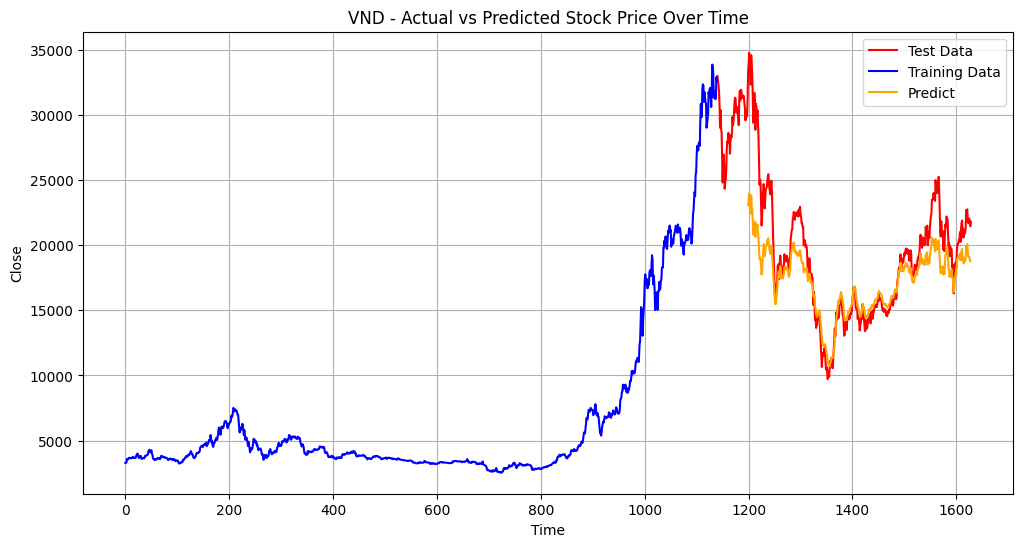

In [23]:
plt.figure(figsize=(12, 6))
n_future = 60

# Plot actual values
plt.plot(range(train_size, train_size+test_size+1),test_back.reshape(-1,1), linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size), train_back, linestyle='-', color='b', label='Training Data')
#predict_date = Test_data['Time'];
plt.plot(range(train_size+n_future-1, train_size+test_size),  y_pred_future, label='Predict', linestyle='-',  color='orange')
# # Plot predicted values
#plt.plot( test_Date, y_pred, label='Predicted', linestyle='-',  color='b')

plt.title('VND - Actual vs Predicted Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
n_past = 1
n_days_for_prediction= 60

#print(test_data.reshape(1,-1).T.shape)

test_for_forecast = test_data.reshape(1,-1).T

x_forecast = []
y_forecast = []

for i in range(n_days_for_prediction):
  # B1 Duyệt dữ liệu test n ngày gần nhất => bỏ vào x tạm
  x = np.array(test_for_forecast[(-60):])
  print(x.shape)
  x = x.T.reshape(x.shape[1], x.shape[0], 1)
  print(x.shape)

  # B2 dùng predict để chạy 1 ngày
  y = model.predict(x)
  # B3 thêm data ngày đó vào y_forecast, test_for_forecast và append x vào x_forecast
  y_c = np.repeat(y, x.shape[1], axis=-1)
  y_pr = scaler.inverse_transform(y_c)[:,0]

  x_forecast.append(x)
  y_forecast.append(y_pr)
  test_for_forecast = np.append(test_for_forecast, y).reshape(-1,1)
  print(test_for_forecast.shape)
  #test_for_forecast.append(y)
  # B4 lặp lại đến ngày thứ 60

x_forecast = np.array(x_forecast)
y_forecast = np.array(y_forecast)

(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 29ms/step
(490, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 32ms/step
(491, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 28ms/step
(492, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 29ms/step
(493, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 27ms/step
(494, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 27ms/step
(495, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 28ms/step
(496, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 31ms/step
(497, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 31ms/step
(498, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 32ms/step
(499, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 27ms/step
(500, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 28ms/step
(501, 1)
(60, 1)
(1, 60, 1)
1/1 [================

In [25]:
print(y_forecast)

[[18972.254]
 [17689.357]
 [17024.45 ]
 [16490.809]
 [16087.234]
 [15801.515]
 [15628.753]
 [15534.266]
 [15501.456]
 [15520.962]
 [15584.39 ]
 [15683.369]
 [15809.893]
 [15956.542]
 [16116.509]
 [16283.305]
 [16450.71 ]
 [16612.83 ]
 [16764.201]
 [16900.012]
 [17016.338]
 [17110.38 ]
 [17180.652]
 [17227.045]
 [17250.787]
 [17254.258]
 [17241.018]
 [17214.545]
 [17178.582]
 [17136.797]
 [17092.523]
 [17048.605]
 [17007.305]
 [16970.287]
 [16938.65 ]
 [16912.996]
 [16893.5  ]
 [16879.992]
 [16872.05 ]
 [16869.059]
 [16870.273]
 [16874.896]
 [16882.12 ]
 [16891.158]
 [16901.229]
 [16911.64 ]
 [16921.82 ]
 [16931.3  ]
 [16939.736]
 [16946.889]
 [16952.627]
 [16956.938]
 [16959.854]
 [16961.473]
 [16961.932]
 [16961.41 ]
 [16960.104]
 [16958.217]
 [16955.941]
 [16953.463]]


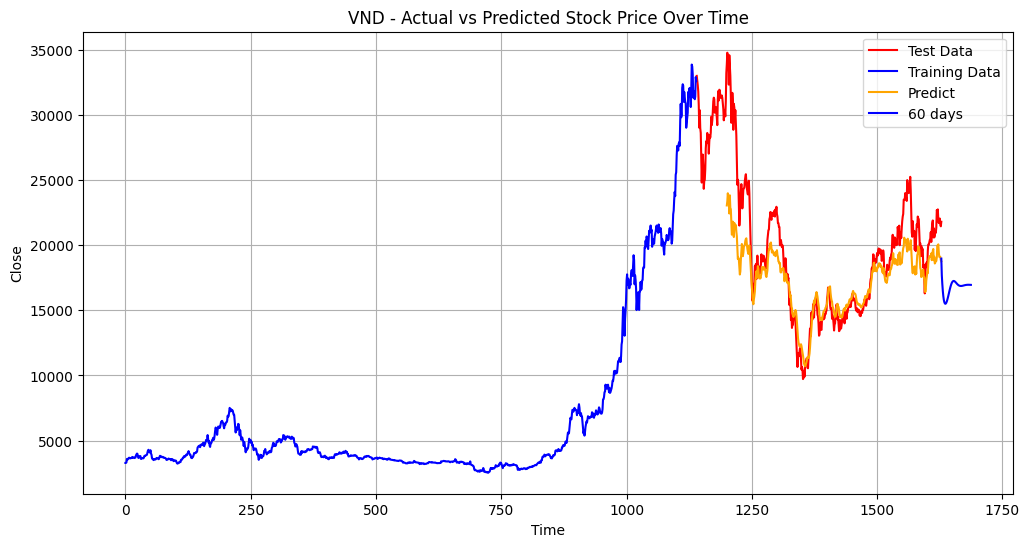

In [26]:
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(range(train_size, train_size+test_size+1),test_back.reshape(-1,1), linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size), train_back, linestyle='-', color='b', label='Training Data')
# Plot predict test and actual test
plt.plot(range(train_size+n_future, train_size+test_size+1),  y_pred_future, label='Predict', linestyle='-',  color='orange')
# Plot 60 days
plt.plot(range(train_size+test_size, train_size+test_size+60), y_forecast, linestyle='-', color='b', label='60 days')

plt.title('VND - Actual vs Predicted Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
def RSME (data1, data2):
    return np.sqrt(np.mean((data1-data2)*(data1-data2)))
def MAE (data1, data2):
    return np.mean(np.absolute(data1-data2))
def MAPE (pred, actual):
    return np.mean(np.absolute((pred-actual)/actual))*100
def MSLE (pred, actual):
    return np.mean((np.log(1+actual)-np.log(1+pred))*(np.log(1+actual)-np.log(1+pred)))

In [28]:
print("RSME: ", RSME(y_pred_future, test_back[-60:]))
print("MAE: ", MAE(y_pred_future, test_back[-60:]))
print("MAPE: ", MAPE(y_pred_future, test_back[-60:]))
print("MSLR: ", MSLE(y_pred_future, test_back[60:]))

RSME:  4256.719954010808
MAE:  3531.5710986821337
MAPE:  16.975140289740708
MSLR:  0.08397500427963893
